# Data encoding/data embedding

Currently, one application of quantum computing is to do machine learning on the classical data. To achieve this, we need to "input" the classical data into the quantum circuit. That is to say, we want to use a quantum state to represent the classical data.

There are a few different ways to do that.

## 1. Basis encoding
   
The most naive encoding. Suitable for discrete data. For example, if you have 3 qubits, you can use it to represent discrete integers from $0$ to $7$. Like $\ket{000}$ represents $0$, $\ket{001}$ represents $1$, and so on.

## 2. Amplitude encoding.

Suppose you have 2 qubits, you can have $\ket{\phi}=c_{00}\ket{00}+c_{01}\ket{01}+c_{10}\ket{10}+c_{11}\ket{11}$. Roughly speaking, we can encode 4 numbers $c_{00},c_{01},c_{10},c_{11}$ into the quantum state. (More precisely, since theses are complex numbers, we can encode 8 real numbers. However, considering the normalization and global phase, we in fact have $8-2=6$ degrees of freedom).

The advantage of this method is that a small number of qubit can represent a large amount of classical data. Suppose each classical data point has $N$ features, then only $\sim\log(N)$ number of qubits are required.

However, even though $n$ qubits can represent $2^n$ numbers, the implementation of this can be costly. Except special cases, it would cost roughly $2^n$ operations.

Another disadvantage is that the type of computation is limited. After you encode the classical input data into the amplitudes, whichever subsequent gates the circuit has, the resulting state will always have coefficients that are proportional to the classical input data. This is to say, it is difficult to have non-linear operations.

For an example of how amplitude encoding can be implemented, see [a pennylane demo](https://pennylane.ai/qml/demos/tutorial_variational_classifier/#iris-classification).

For more information, see *Supervised Learning with Quantum Computers* by Schuld and Petruccione.

## 3. Angle encoding

When you have a number $x$ and want to encode it in a qubit, you can encode the data by the rotation angle $\ket{0}\rightarrow R(x)\ket{0}$. Here, the rotation $R$ may refer to $R_x$, $R_y$, or $R_z$. 

When you have $n$ qubits, you can rotate each of them separately. Thus, you can encode at most $n$ real numbers into a quantum state.

### ZFeatureMap
In qiskit, the built-in ZFeatureMap is a variant of the angle encoding. After Hardmard gate, we impose rotations around the Z axis; the rotation angles can serve as the classical input. 

Let's first look at a one qubit example.

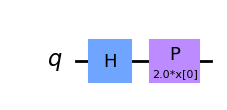

In [1]:
from qiskit.circuit.library import ZFeatureMap

z_feature_map=ZFeatureMap(1, reps=1)
z_feature_map.decompose().draw(output="mpl", style="clifford")

Here, the $P$ gate refers to the phase gate. It differs from the $R_z$ just by a global phase.


$$
P( \lambda ) =\begin{pmatrix}
1 & 0\\
0 & e^{i\lambda }
\end{pmatrix}
$$

In this case, we have a classical input $x_0$. Using the ZFeatureMap, we get the following quantum state

$$
\frac{1}{\sqrt{2}}\left(\ket{0} +e^{2ix_{0}}\ket{1}\right).
$$

 

What happens if we increase the repetition number from $1$ to $2$? We get the following circuit.

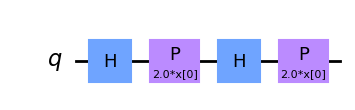

In [2]:
z_feature_map=ZFeatureMap(1, reps=2)
z_feature_map.decompose().draw(output="mpl", style="clifford")

We get $\ \begin{aligned}
 & \frac{1}{2}\left(\left( 1+e^{2ix_{0}}\right)\ket{0} +\left( e^{2ix_{0}} -e^{4ix_{0}}\right)\ket{1}\right)
\end{aligned}$, which may be more complicated than the `reps=1` case.

Now, let's look at a 2-qubit example.

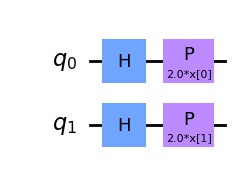

In [3]:
z_feature_map=ZFeatureMap(2, reps=1)
z_feature_map.decompose().draw(output="mpl", style="clifford")




Take the above circuit for example. For classical data $x_0$ and $x_1$, the corresponding quantum state will be

$$
\begin{aligned}
\ket{\phi } & =\frac{1}{\sqrt{2}}\left(\ket{0} +e^{2ix_{0}}\ket{1}\right) \otimes \frac{1}{\sqrt{2}}\left(\ket{0} +e^{2ix_{1}}\ket{1}\right)\\
 & =\frac{1}{\left(\sqrt{2}\right)^{2}}\left(\ket{00} +e^{2ix_{0}}\ket{10} +e^{2ix_{1}}\ket{01} +e^{2i( x_{0} +x_{1})}\ket{11}\right)
\end{aligned}
$$

The ZFeatureMap rotates each qubit independently, so it does not create entanglement.

To make full use of the quantum nature of the circuit, people have developed more complicated feature maps.

## Other encodings



### ZZFeatureMap

Compared to ZFeatureMap, ZZFeatureMap is more complicated. While both work by rotating the qubits by an angle according to the input data, ZZFeatureMap will create entanglement between the qubits, unlike ZFeatureMap. 

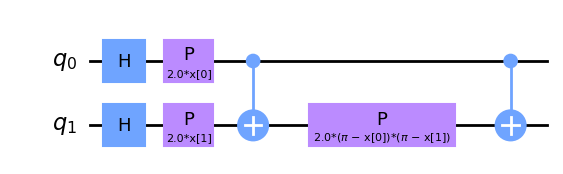

In [4]:
from qiskit.circuit.library import ZZFeatureMap

zz_feature_map=ZZFeatureMap(2, reps=1)
zz_feature_map.decompose().draw(output="mpl", style="clifford")

In short, ZZFeatureMap is defined as

$$
\ket{0^n}\rightarrow  U_{\phi(\vec x)}H^{\otimes n}\ket{0^n},
$$
with $U_{\phi(\vec x)}$ defined as 
$$
U_{\phi(\vec x)}=\exp\left(i\sum_i x_i Z_i +i\sum_{i,j} (\pi-x_i)(\pi-x_j) Z_i Z_j\right),
$$
where $Z_i$ is the Pauli Z matrix at qubit $i$.

Here, since $Z_i$ and $Z_i Z_j$ commute with each other, we may write $U_{\phi(\vec x)}=\exp\left(i\sum_{i,j} (\pi-x_i)(\pi-x_j) Z_i Z_j\right)\exp\left(i\sum_i x_i Z_i \right)$. 

That is to say, the feature map looks like 
$$
\ket{0^n}\rightarrow  \exp\left(i\sum_{i,j} (\pi-x_i)(\pi-x_j) Z_i Z_j\right)\exp\left(i\sum_i x_i Z_i \right)H^{\otimes n}\ket{0^n}.
$$

Now, let's look at how the circuit above correspond to this formula.

The circuit can be divided into three parts.


1. First part is the Hadamard gates.

The following circuit correspond to 

$$
H^{\otimes n}.
$$

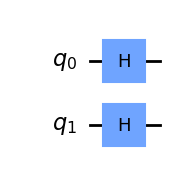

In [5]:
# hardmard gates
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h([0, 1])

qc.draw('mpl', style='clifford')

2. The second part is the single qubit Z-rotation matrices.

Up to some constant phase, the following circuit is 

$$
\exp\left(i\sum_i x_i Z_i \right).
$$

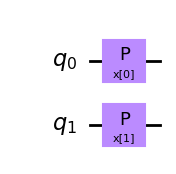

In [6]:
# second part: single qubit rotations

from qiskit.circuit import Parameter, ParameterVector

qc = QuantumCircuit(2)
xs = ParameterVector('x', 2)

qc.p(xs[0], 0)
qc.p(xs[1], 1)

qc.draw('mpl', style='clifford')

3. The third part is the 2-qubit ZZ-rotation matrices.

$$
\exp\left(i\sum_{i,j} (\pi-x_i)(\pi-x_j) Z_i Z_j\right).
$$

As you can see, this is realized by applying a $Z$-rotation on qubit-1, sandwiched by two $CNOT$ gates from qubit 0. To see how this works, simply plug in the basis states $\ket{00}$, $\ket{01}$, $\ket{10}$, and $\ket{11}$, and you will see that it indeed gives you an operator of the form $\exp(i\theta Z_0Z_1)$.

/tmp/ipykernel_57491/4131280522.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(0, 1)
/tmp/ipykernel_57491/4131280522.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(0, 1)


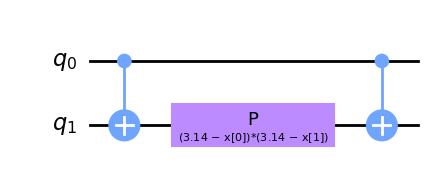

In [7]:
# third part: 2-qubit rotation

qc = QuantumCircuit(2)
xs = ParameterVector('x', 2)

qc.cnot(0, 1)
qc.p((3.14-xs[0])*(3.14-xs[1]), 1)
qc.cnot(0, 1)

qc.draw('mpl', style='clifford')

The circuit above implements $\exp\left(i\sum_{i,j} (\pi-x_i)(\pi-x_j) Z_i Z_j\right)$ up to some global phase (and maybe also up to a minus sign in the exp).

Together, the three parts implement the ZZFeatureMap

$$
\ket{0^n}\rightarrow  U_{\phi(\vec x)}H^{\otimes n}\ket{0^n},
$$
with $U_{\phi(\vec x)}$ defined as 
$$
U_{\phi(\vec x)}=\exp\left(i\sum_i x_i Z_i +i\sum_{i,j} (\pi-x_i)(\pi-x_j) Z_i Z_j\right),
$$

### Comments about ZZFeatureMap

ZZFeatureMap is different from ZFeatureMap in that ZZFeatureMap creates entanglement. Thus, in some sense, ZZFeatureMap is more "quantum" than ZFeatureMap.

ZZFeatureMap is originally proposed by [this paper](https://www.nature.com/articles/s41586-019-0980-2). It was designed for the kernel methods. The reason why the authors proposed ZZFeatureMap is that they conjectured that the kernel obtained with ZZFeatureMap would be difficult to calculate classically, thus ZZFeatureMap would offer quantum advantage.

Also see the discussion on [Stackexchange](https://quantumcomputing.stackexchange.com/questions/26552/how-well-different-featuremap-encode-the-data).

## other encodings

__TODO__

## Resources

https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PauliFeatureMap

https://qml.baidu.com/tutorials/machine-learning/encoding-classical-data-into-quantum-states.html

https://pennylane.ai/qml/glossary/quantum_embedding/

https://www.nature.com/articles/s41586-019-0980-2

https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/machine_learning/custom_feature_map.ipynb

https://quantumcomputing.stackexchange.com/questions/26552/how-well-different-featuremap-encode-the-data